In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# helper function to plot curves
def make_plot(metric_values, train_values, cv_values, model_name, metric_name, score_name, curve_type):
    
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(metric_values, train_values, label='Training score')
    ax.plot(metric_values, cv_values, label='CV score')
    ax.set_xlabel(metric_name)
    ax.set_ylabel(score_name)
    title = '{} curve for {} ({})'.format(curve_type, model_name, score_name)
    ax.set_title(title)
    ax.legend()
    
def plot_curve(model, model_name, X, y, param_name, scoring, curve_type, param_range=None):
    
    if curve_type == 'Validation':
        train_scores, cv_scores = validation_curve(model, X, y,
                                                   param_name=param_name, 
                                                   param_range=param_range, 
                                                   scoring=scoring,
                                                   cv=5,
                                                   n_jobs=-1)
    elif curve_type == 'Learning':
        train_sizes, train_scores, cv_scores = learning_curve(model, X, y,
                                                              train_sizes=np.linspace(.1, 1.0, 100),
                                                              scoring=scoring,
                                                              cv=5,
                                                              n_jobs=-1)
        param_range = train_sizes
        
    train_score_means = np.mean(train_scores, axis=1)
    cv_score_means = np.mean(cv_scores, axis=1)
    
    make_plot(metric_values=param_range,
              train_values=train_score_means,
              cv_values = cv_score_means,
              model_name=model_name, 
              metric_name=param_name.capitalize().replace('_',' '),
              score_name=scoring.capitalize(),
              curve_type=curve_type
             )

## Red & White Wine Dataset

In [4]:
df_white = pd.read_csv('winequality-white.csv', sep=';')
df_red = pd.read_csv('winequality-red.csv', sep=';')

df_white['type'] = ['white'] * len(df_white)
df_red['type'] = ['red'] * len(df_red)

df = pd.concat([df_white, df_red])

X = df.drop(['quality', 'type'], axis=1) 
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2020) 

# In data_exploration we see almost all features have a normal distribution 
# So it makes sense to use StandardScaler
scaler = StandardScaler()
encoder = LabelEncoder() 

# Apply the scaler on train and test data separately
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
y_train = encoder.fit_transform(y_train)

X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns) 
y_test = encoder.fit_transform(y_test)

**Train a basic MLPClassifier and keep max_iter at 100 and hidden layers as the number of inputs for simplicity.**

In [5]:
clf = MLPClassifier(random_state=2020, 
                    hidden_layer_sizes=len(X.columns),
                    max_iter=100)

**But look at how the number of hidden units affects classifier accuracy.**

CPU times: user 119 ms, sys: 53.4 ms, total: 173 ms
Wall time: 20.7 s


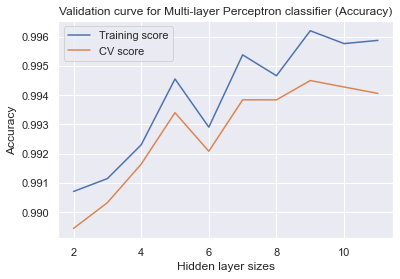

In [6]:
%%time
num_hidden_units = list(range(2,len(X.columns)+1))
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='hidden_layer_sizes',
           param_range=num_hidden_units,  
           scoring='accuracy', 
           curve_type='Validation')

**We can  see that more hidden layers is better up to a certain threshold.**

**Look at how max iterations affect classifier accuracy**

CPU times: user 735 ms, sys: 89.6 ms, total: 824 ms
Wall time: 1min 30s


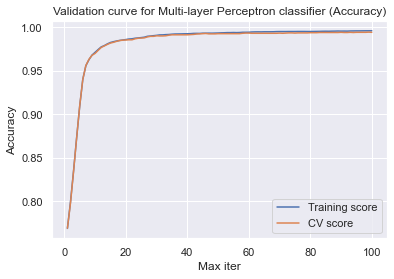

In [7]:
%%time
max_iter_range = list(range(1,101))
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_iter',
           param_range=max_iter_range,  
           scoring='accuracy', 
           curve_type='Validation')

**Narrow down the range to get a better picture.**

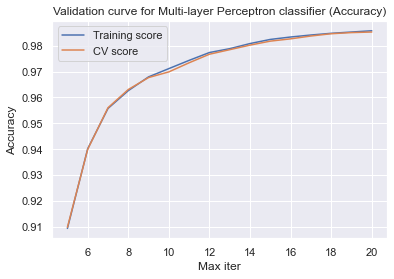

In [8]:
max_iter_range = list(range(5,21))
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_iter',
           param_range=max_iter_range,  
           scoring='accuracy', 
           curve_type='Validation')

**Here, we see that we don't actually need many iterations, and the network can be trained with just a couple dozen.**

**Now, let's try to figure out the value of the regularization parameter alpha.**

CPU times: user 98.6 ms, sys: 11.2 ms, total: 110 ms
Wall time: 16.5 s


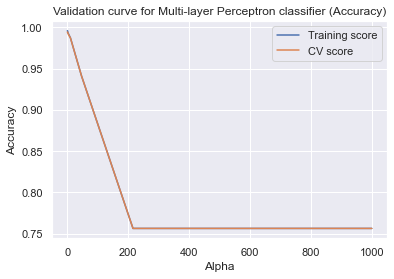

In [9]:
%%time
alpha_range = np.logspace(-3, 3, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='alpha',
           param_range=alpha_range,  
           scoring='accuracy', 
           curve_type='Validation')

**Clearly, the range is too big. Let's try reducing it.**

CPU times: user 93.2 ms, sys: 10.6 ms, total: 104 ms
Wall time: 15.8 s


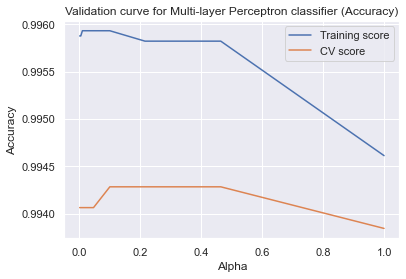

In [10]:
%%time
alpha_range = np.logspace(-3, 0, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='alpha',
           param_range=alpha_range,  
           scoring='accuracy', 
           curve_type='Validation')

**And again**

CPU times: user 154 ms, sys: 16 ms, total: 170 ms
Wall time: 16.2 s


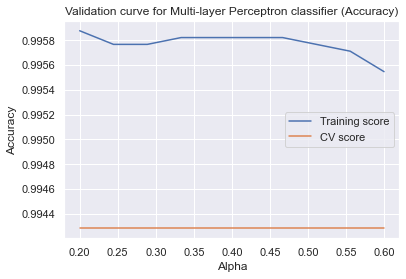

In [11]:
%%time
alpha_range = np.linspace(0.2, 0.6, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='alpha',
           param_range=alpha_range,  
           scoring='accuracy', 
           curve_type='Validation')

**We can see here that the value of regularization parameter needs to stay small.**

**Now we can check model learning rate parameter.**

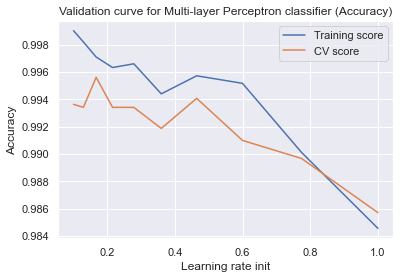

In [12]:
learning_rate_range = np.logspace(-1, 0, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate_init',
           param_range=learning_rate_range,  
           scoring='accuracy', 
           curve_type='Validation')

**Reduce the range**

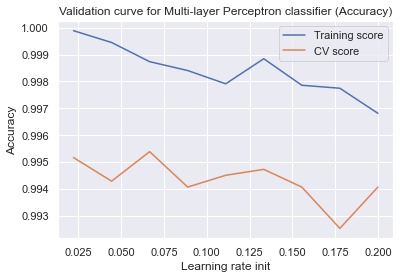

In [13]:
learning_rate_range = np.linspace(0, 0.2, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate_init',
           param_range=learning_rate_range,  
           scoring='accuracy', 
           curve_type='Validation')

**Perform grid search.**

In [14]:
%%time
search_parameters = {'alpha':np.linspace(0.3, 0.5, 10),
                     'learning_rate_init':np.linspace(0, 0.075, 10),
                     'max_iter':list(range(8,16))
                    }
gs_clf = GridSearchCV(clf, search_parameters, cv=5, scoring='accuracy', n_jobs=-1)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_params_)

{'alpha': 0.3, 'learning_rate_init': 0.041666666666666664, 'max_iter': 13}
CPU times: user 6.29 s, sys: 662 ms, total: 6.95 s
Wall time: 2min 54s


**Use these parameters + hidden_layers = 9 from the first graph.**

In [15]:
%%time
clf = MLPClassifier(hidden_layer_sizes=(9,), 
                    random_state=2020, 
                    max_iter=13,
                    alpha=0.3,
                    activation='logistic',
                    learning_rate_init=0.041666666666666664
               )
clf.fit(X_train, y_train)

CPU times: user 154 ms, sys: 3.06 ms, total: 158 ms
Wall time: 220 ms


MLPClassifier(activation='logistic', alpha=0.3, hidden_layer_sizes=(9,),
              learning_rate_init=0.041666666666666664, max_iter=13,
              random_state=2020)

**Now we can plot the learning rate for the model.**

CPU times: user 785 ms, sys: 93.2 ms, total: 879 ms
Wall time: 18.2 s


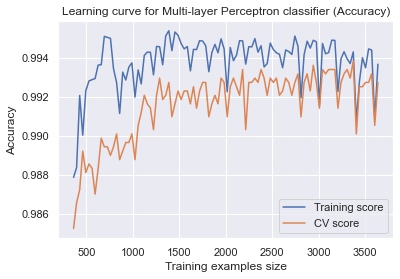

In [16]:
%%time
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='Training examples size', 
           scoring='accuracy', 
           curve_type='Learning')

**And evaluate on test data.**

In [17]:
%%time
y_predicted = clf.predict(X_test)

CPU times: user 5.11 ms, sys: 3.04 ms, total: 8.15 ms
Wall time: 14.2 ms


In [18]:
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9917    0.9715    0.9815       491
           1     0.9905    0.9973    0.9939      1459

    accuracy                         0.9908      1950
   macro avg     0.9911    0.9844    0.9877      1950
weighted avg     0.9908    0.9908    0.9907      1950



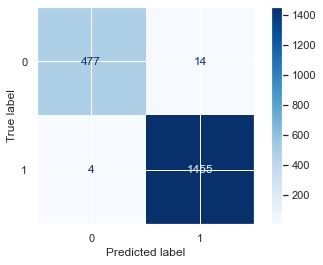

In [19]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=[0,1]);

## Shill Bidding Dataset

In [20]:
df = pd.read_csv("Shill Bidding Dataset.csv")

X = df.drop(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2020) 

# Use MinMaxScaler because data has outliers, and we want to highlight those
scaler = MinMaxScaler() 

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns) 

**Train a basic classifier and use simple parameters, like with the previous dataset.**

In [21]:
clf = MLPClassifier(random_state=2020, 
                    hidden_layer_sizes=len(X.columns),
                    max_iter=100)

In [22]:
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=9, max_iter=100, random_state=2020)

**Look at how the number of hidden units affects classifier recall.**

CPU times: user 92.1 ms, sys: 11.7 ms, total: 104 ms
Wall time: 14.9 s


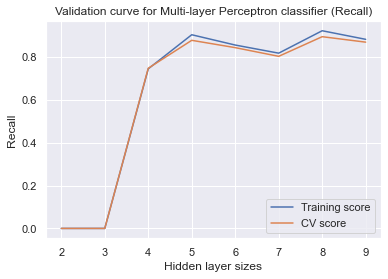

In [23]:
%%time
num_hidden_units = list(range(2,len(X.columns)+1))
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='hidden_layer_sizes',
           param_range=num_hidden_units,  
           scoring='recall', 
           curve_type='Validation')

**Narrow down the range.**

CPU times: user 223 ms, sys: 19.2 ms, total: 242 ms
Wall time: 47.9 s


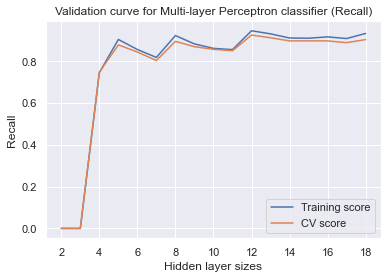

In [24]:
%%time
num_hidden_units = list(range(2,len(X.columns)+10))
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='hidden_layer_sizes',
           param_range=num_hidden_units,  
           scoring='recall', 
           curve_type='Validation')

**Look at how max iterations affect classifier recall.**

CPU times: user 934 ms, sys: 102 ms, total: 1.04 s
Wall time: 1min 59s


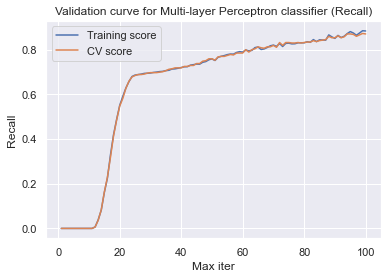

In [25]:
%%time
max_iter_range = list(range(1,101))
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_iter',
           param_range=max_iter_range,  
           scoring='recall', 
           curve_type='Validation')

**Change the range.**

CPU times: user 406 ms, sys: 43.9 ms, total: 450 ms
Wall time: 1min 14s


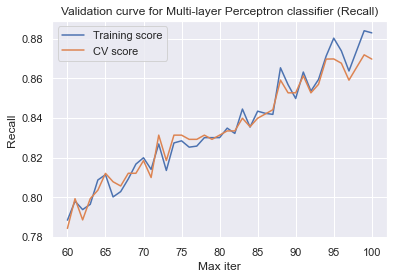

In [26]:
%%time
max_iter_range = list(range(60,101))
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_iter',
           param_range=max_iter_range,  
           scoring='recall', 
           curve_type='Validation')

**Change the range again.**

CPU times: user 1.05 s, sys: 110 ms, total: 1.16 s
Wall time: 5min 1s


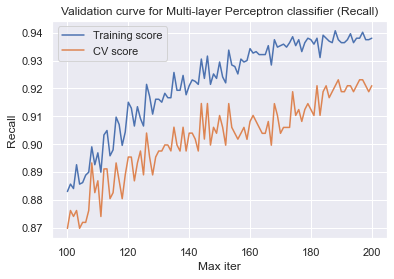

In [27]:
%%time
max_iter_range = list(range(100,201))
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_iter',
           param_range=max_iter_range,  
           scoring='recall', 
           curve_type='Validation')

**And again.**

CPU times: user 891 ms, sys: 97.8 ms, total: 989 ms
Wall time: 5min 40s


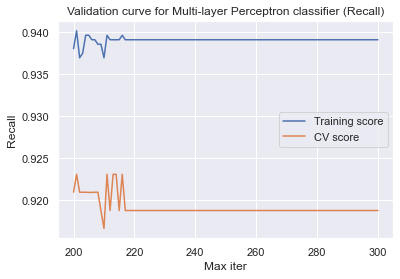

In [28]:
%%time
max_iter_range = list(range(200,301))
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='max_iter',
           param_range=max_iter_range,  
           scoring='recall', 
           curve_type='Validation')

**Clearly, after 200 iterations, the recall does not improve.**

**Now check the regularization parameter alpha.**

CPU times: user 109 ms, sys: 11.1 ms, total: 120 ms
Wall time: 16.5 s


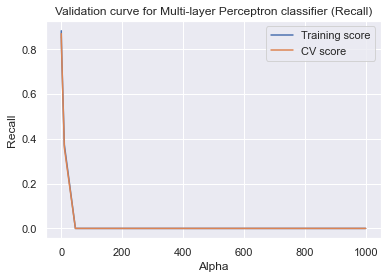

In [29]:
%%time
alpha_range = np.logspace(-3, 3, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='alpha',
           param_range=alpha_range,  
           scoring='recall', 
           curve_type='Validation')

**Narrow down the range.**

CPU times: user 115 ms, sys: 11.7 ms, total: 127 ms
Wall time: 17.6 s


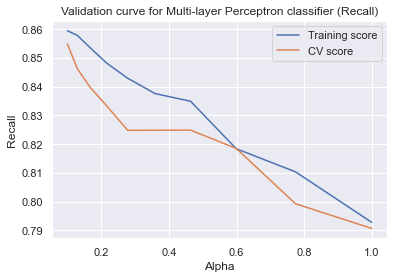

In [30]:
%%time
alpha_range = np.logspace(-1, 0, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='alpha',
           param_range=alpha_range,  
           scoring='recall', 
           curve_type='Validation')

**And refine this search again.**

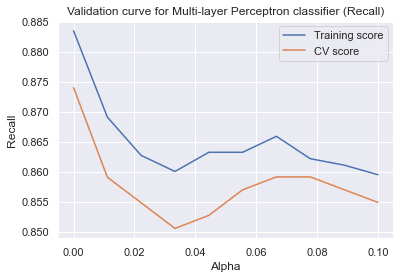

In [31]:
alpha_range = np.linspace(0, 0.1, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='alpha',
           param_range=alpha_range,  
           scoring='recall', 
           curve_type='Validation')

**Now look at how the learning rate parameter affects classifier recall.**

CPU times: user 104 ms, sys: 10.1 ms, total: 114 ms
Wall time: 7.35 s


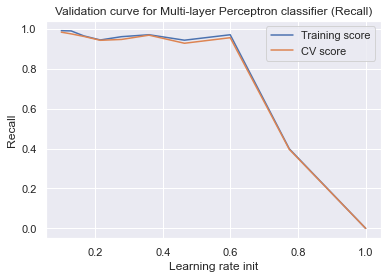

In [32]:
%%time
learning_rate_range = np.logspace(-1, 0, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate_init',
           param_range=learning_rate_range,  
           scoring='recall', 
           curve_type='Validation')

**Refine the range.**

CPU times: user 104 ms, sys: 10.3 ms, total: 115 ms
Wall time: 4.88 s


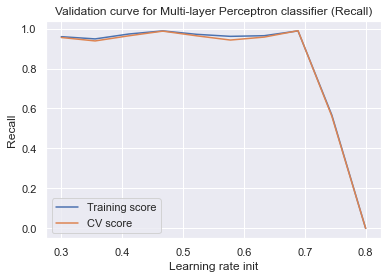

In [33]:
%%time
learning_rate_range = np.linspace(0.3, 0.8, 10)
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='learning_rate_init',
           param_range=learning_rate_range,  
           scoring='recall', 
           curve_type='Validation')

**Perform grid search.**

In [34]:
%%time
search_parameters = {'alpha':np.linspace(0.04, 0.08, 10),
                     'learning_rate_init':np.linspace(0.5, 0.7, 10)
                    }
gs_clf = GridSearchCV(clf, search_parameters, cv=5, scoring='recall', n_jobs=-1)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_params_)

{'alpha': 0.07111111111111111, 'learning_rate_init': 0.5}
CPU times: user 1.26 s, sys: 106 ms, total: 1.37 s
Wall time: 44.6 s


**Max iterations and number of hidden units can be deduced from the graphs above, and the values for alpha and the learnign rate are collected from grid search to design the final model.**

In [35]:
%%time
clf = MLPClassifier(hidden_layer_sizes=(12,), 
                    random_state=2020, 
                    max_iter=180,
                    alpha=0.07111111111111111,
                    activation='logistic',
                    learning_rate_init=0.5
               )
clf.fit(X_train, y_train)

CPU times: user 166 ms, sys: 1.82 ms, total: 168 ms
Wall time: 168 ms


MLPClassifier(activation='logistic', alpha=0.07111111111111111,
              hidden_layer_sizes=(12,), learning_rate_init=0.5, max_iter=180,
              random_state=2020)

**Check the learning curve.**

CPU times: user 693 ms, sys: 64.5 ms, total: 757 ms
Wall time: 30.5 s


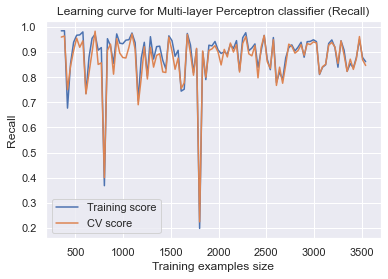

In [36]:
%%time
plot_curve(model=clf,
           model_name='Multi-layer Perceptron classifier', 
           X=X_train, 
           y=y_train, 
           param_name='Training examples size', 
           scoring='recall', 
           curve_type='Learning')

**And see how the model performs on test data.**

In [37]:
%%time
y_predicted = clf.predict(X_test)

CPU times: user 3.34 ms, sys: 926 µs, total: 4.27 ms
Wall time: 3.91 ms


In [38]:
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9988    0.9840    0.9914      1690
           1     0.8836    0.9903    0.9339       207

    accuracy                         0.9847      1897
   macro avg     0.9412    0.9872    0.9626      1897
weighted avg     0.9862    0.9847    0.9851      1897



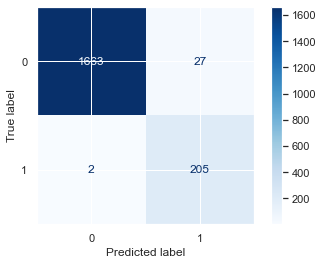

In [39]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=[0,1]);